

# Fig 3 options

1. balls per age group (same info as Fig 2b)
2. something separating urban vs. rural
3. CDF or similar showing most/least affected
4. WBGTi in T,qs space
5. Conceptual figure on distributions changing in a specific spot (get eCDF from models and theoretical distr from reanalysis and cfr with reanalysis 10 years distribution changing in space - for a given month)
6. Something with some regional information
7. Something per GW level !! 

Luthi code for balls: 

In [1]:
# necessary: netcdf4-python, regionmask, (xarray, geopandas), cartopy, openpyxl, statsmodels

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.image as mpimg
from matplotlib.patches import Circle
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import LogNorm
%matplotlib inline 
plt.rcdefaults()

import numpy as np
import pandas as pd

# import fxns 
from functions_ana import *
from utils_ana import *
from plotscript import *

# import other packages/modules 
sys.path.append(os.path.join(os.environ['VSC_DATA_VO_USER'],'demographics4climate/')) #hpc
from population_demographics import * 

In [2]:
dirname='output_empirical'
models='ISIMIP3b'
figdir = os.path.join(figdirs, 'fig_sep24')


## Petri dish: Functions

In [3]:
'''------------------------------------------------------------------------'''
''' Plot petridish '''

class Point:
    """A little class representing an SVG circle."""

    def __init__(self, cx, cy, r, icolour=None):
        """Initialize the circle with its centre, (cx,cy) and radius, r.

        icolour is the index of the circle's colour.

        """
        self.cx, self.cy, self.r = cx, cy, r
        self.icolour = icolour

    def overlap_with(self, cx, cy, r):
        """Does the circle overlap with another of radius r at (cx, cy)?"""

        d = np.hypot(cx-self.cx, cy-self.cy)
        return d < r + self.r

class PointCloud:
    """A class for drawing circles-inside-a-circle.
    Inspired by https://scipython.com/blog/packing-circles-in-a-circle/
    """

    def __init__(self, width=600, height=600, R=250, n=800, rho_min=0.005,
                 rho_max=0.05, colours=None):
        """Initialize the Circles object.

        width, height are the SVG canvas dimensions
        R is the radius of the large circle within which the small circles are
        to fit.
        n is the maximum number of circles to pack inside the large circle.
        rho_min is rmin/R, giving the minimum packing circle radius.
        rho_max is rmax/R, giving the maximum packing circle radius.
        colours is a list of SVG fill colour specifiers to be referenced by
            the class identifiers c<i>. If None, a default palette is set.

        """

        self.width, self.height = width, height
        self.R, self.n = R, n
        # The centre of the canvas
        self.CX, self.CY = self.width // 2, self.height // 2
        self.rmin, self.rmax = R * rho_min, R * rho_max
        self.colours = colours or ['#993300', '#a5c916', '#00AA66', '#FF9900']

   
    def _place_circle(self, r):
        # The guard number: if we don't place a circle within this number
        # of trials, we give up.
        guard = 500
        while guard:
            # Pick a random position, uniformly on the larger circle's interior
            cr, cphi = ( self.R * np.sqrt(np.random.random()),
                         2*np.pi * np.random.random() )
            cx, cy = cr * np.cos(cphi), cr * np.sin(cphi)
            if cr+r < self.R:
            # The circle fits inside the larger circle.
                if not any(circle.overlap_with(self.CX+cx, self.CY+cy, r)
                                    for circle in self.circles):
                    # The circle doesn't overlap any other circle: place it.
                    circle = Point(cx+self.CX, cy+self.CY, r,
                                icolour=np.random.randint(len(self.colours)))
                    self.circles.append(circle)
                    return
            guard -= 1
        # Warn that we reached the guard number of attempts and gave up for
        # for this circle.
        print('guard reached.')

    def make_circles(self):
        """Place the little circles inside the big one."""

        # First choose a set of n random radii and sort them. We use
        # random.random() * random.random() to favour small circles.
        self.circles = []
        r = self.rmin + (self.rmax - self.rmin) * np.random.random(
                                self.n) * np.random.random(self.n)
        r[::-1].sort()
        # Do our best to place the circles, larger ones first.
        for i in range(self.n):
            self._place_circle(r[i])



In [4]:
def prep_data_petri_dish(da, ages=[80,60,40,20,0],cmap='inferno_r',gray=True): # MY VERSION
    cm = plt.get_cmap(cmap)
    cols = [cm(i / 10) for i in range(10)]
    
    # make colors for petri dishes
    c = np.arange(0,100,1); col_lvls = dict(); al_lvls = dict()
    
    ages = [80,60,40,20,0]
    
    for i, age in enumerate(ages):
        props = np.empty(len(da_prop_people_ndays_models.features))
        for j in range(len(da_prop_people_ndays_models.features)):
            prop = da.sel(age_ranges=age).to_pandas().median(axis=0)[j]
            props[j] = prop

        print(age, [round(props[i],2) for i in range(len(da_prop_people_ndays_models.features))] )
        
        al = []; col = []
        for j in c:
            if j < np.round(props[-1]*100): col.append(cols[9]); al.append(1) 
            elif j < np.round(props[-2]*100): col.append(cols[6]); al.append(0.8)
            elif j < np.round(props[-3]*100): col.append(cols[3]); al.append(0.6)
            elif j < np.round(props[-4]*100): col.append(cols[1]); al.append(0.4)
            else: col.append('gray'); al.append(0.15)
    
        col_lvls[i] = col
        al_lvls[i] = al

    return col_lvls, al_lvls


In [5]:
def plot_petri_dish_2lvls(col_lvls, al_lvls, col_lvls_15=None, al_lvls_15=None, 
                          col_lvls_2=None, al_lvls_2=None, nrows=1, title='', 
                          labels=['Global warming \nto 2023', '1.5$\degree$C', '2$\degree$C'], 
                          sort_points=False,
                         legtitle='Attributable days per year'):

    R = 65
    
    def plot_circle_row(ax, col_lvls, al_lvls, wl_name, sort_points, row_offset=0):
        """Helper function to plot a row of circles."""
        for w, wlevel in enumerate(wl_name):
            cloud = PointCloud(width=100, height=100, R=R, n=100, rho_min=0.065, rho_max=0.065)
            cloud.make_circles()

            while len(cloud.circles) < 100:
                cloud = PointCloud(width=100, height=100, R=R, n=100, rho_min=0.065, rho_max=0.065)
                cloud.make_circles()

            cx = np.array([c.cx for c in cloud.circles])
            cy = np.array([c.cy for c in cloud.circles])

            if sort_points:
                r = (cx - 50.) ** 2 + (cy - 50) ** 2
                r_ind = 99 - np.argsort(r.argsort())
                col = [col_lvls[w][i] for i in r_ind]
                al = [al_lvls[w][i] for i in r_ind]
            else:
                col = col_lvls[w]
                al = al_lvls[w]

            ax[w + row_offset].scatter(cx, cy, s=200, marker='o', c=col, alpha=al)
            ax[w + row_offset].add_patch(Circle((50, 50), R, facecolor='none', edgecolor='black', linewidth=1, alpha=1))
            ax[w + row_offset].axis('off')
            ax[w + row_offset].set_aspect('equal')
            if row_offset == 0:
                ax[w + row_offset].set_title(wlevel, fontsize=24)
    
    ages = [80, 60, 40, 20, 0]
    wl_name = [f'{age}-{age + 9}' for age in ages]  # Age levels

    fig, axes = plt.subplots(nrows, 5, figsize=(18, 4 * nrows))
    plt.suptitle(title, fontsize=32)
    
    axes = axes.flatten()
    plot_circle_row(axes, col_lvls, al_lvls, wl_name, sort_points)

    if nrows > 1:
        plot_circle_row(axes, col_lvls_15, al_lvls_15, wl_name, sort_points, row_offset=len(wl_name))

    if nrows > 2:
        plot_circle_row(axes, col_lvls_2, al_lvls_2, wl_name, sort_points, row_offset=2 * len(wl_name))

    plt.subplots_adjust(bottom=0.2, 
                        wspace=0.1, 
                        hspace=0.1)

    # Create legend
    cm = plt.get_cmap('inferno_r')
    cols = [cm(i / 10) for i in range(10)]
    p0 = plt.plot(np.NaN, np.NaN, color='gray', markersize=15, marker='o', linestyle='', alpha=.3)
    p1 = plt.plot(np.NaN, np.NaN, color=cols[1], markersize=15, marker='o', linestyle='')
    p2 = plt.plot(np.NaN, np.NaN, color=cols[3], markersize=15, marker='o', linestyle='')
    p3 = plt.plot(np.NaN, np.NaN, color=cols[6], markersize=15, marker='o', linestyle='')
    p4 = plt.plot(np.NaN, np.NaN, color=cols[9], markersize=15, marker='o', linestyle='')

    leg = plt.legend([p0[0], p1[0], p2[0], p3[0], p4[0]],
                     [f'$\leq${x_hot_days[1]}', f'{x_hot_days[1]}-{x_hot_days[2]}',
                      f'{x_hot_days[2]}-{x_hot_days[3]}', f'{x_hot_days[3]}-{x_hot_days[4]}',
                      f'$\geq${x_hot_days[4]}'],
                     loc='lower center', ncol=5, bbox_to_anchor=(-1.8, -0.25),
                     fontsize=18, frameon=False) #title=legtitle)

    plt.annotate(legtitle, (.5, .075),xycoords='figure fraction', fontsize=18, ha='center')
    
    y_positions = [0.7, 0.46, 0.23]  


    if nrows >= 2:
        plt.annotate(labels[0], (.07, y_positions[0]), xycoords='figure fraction', fontsize=18, ha='center', fontweight='bold')
        plt.annotate(labels[1], (.07, y_positions[1]), xycoords='figure fraction', fontsize=18, ha='center', fontweight='bold')
    if nrows == 3:
        plt.annotate(labels[2], (.07, y_positions[2]), xycoords='figure fraction', fontsize=18, ha='center', fontweight='bold')

   #plt.show()


## Prep data: demographics



In [6]:
gs_population_global_2023 = population_demographics_gridscale_global(startyear=2023,
                                                                endyear=2023,
                                                                ssp=2,
                                                                urbanrural=False)

loading country masks
interpolating cohort sizes per country
calculating gridscale demographics


In [7]:
gs_population_global_2034 = population_demographics_gridscale_global(startyear=2034,
                                                                endyear=2034,
                                                                ssp=2,
                                                                urbanrural=False)

loading country masks
interpolating cohort sizes per country
calculating gridscale demographics


In [8]:
gs_population_global_2062 = population_demographics_gridscale_global(startyear=2062,
                                                                endyear=2062,
                                                                ssp=2,
                                                                urbanrural=False)

loading country masks
interpolating cohort sizes per country
calculating gridscale demographics


In [9]:
gs_population_global_2050 = population_demographics_gridscale_global(startyear=2050,
                                                                endyear=2050,
                                                                ssp=2,
                                                                urbanrural=False)

loading country masks
interpolating cohort sizes per country
calculating gridscale demographics


## Prep data: climate

In [34]:
x_hot_days = [0, 1, 50, 100, 150]

year=2023

In [35]:


da_nAHD_models = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, year_pres=year) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models

da_n_people_ndays_models, da_prop_people_ndays_models = calc_number_proportion_people_atleastxdays_10yr(gs_population_global_2023, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = x_hot_days)





In [36]:

temp_target=1.5

da_nAHD_models = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, temp_target=temp_target) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models

da_n_people_ndays_models_15, da_prop_people_ndays_models_15 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global_2034, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = x_hot_days)



In [37]:

temp_target=2

da_nAHD_models = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, temp_target=temp_target) # see here i coded what models it is in the fxn 

da_nAHD = da_nAHD_models

da_n_people_ndays_models_2, da_prop_people_ndays_models_2 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global_2062, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = x_hot_days)




In [38]:
da_prop_people_ndays_models.sel(age_ranges=0).to_pandas().median(axis=0)


features
prop_atleast_0      0.998699
prop_atleast_1      0.899842
prop_atleast_50     0.354393
prop_atleast_100     0.13503
prop_atleast_150    0.032833
dtype: object

In [39]:
col_lvls, al_lvls = prep_data_petri_dish(da_prop_people_ndays_models)


80 [1.0, 0.77, 0.14, 0.05, 0.02]
60 [1.0, 0.84, 0.2, 0.07, 0.02]
40 [1.0, 0.88, 0.26, 0.1, 0.03]
20 [1.0, 0.9, 0.31, 0.12, 0.03]
0 [1.0, 0.9, 0.35, 0.14, 0.03]


In [40]:
col_lvls_15, al_lvls_15 = prep_data_petri_dish(da_prop_people_ndays_models_15)


80 [1.0, 0.82, 0.17, 0.06, 0.03]
60 [1.0, 0.89, 0.25, 0.1, 0.03]
40 [1.0, 0.9, 0.31, 0.13, 0.04]
20 [1.0, 0.91, 0.37, 0.16, 0.05]
0 [1.0, 0.92, 0.41, 0.18, 0.05]


In [41]:
col_lvls_2, al_lvls_2 = prep_data_petri_dish(da_prop_people_ndays_models_2)


80 [1.0, 0.9, 0.33, 0.13, 0.07]
60 [1.0, 0.93, 0.43, 0.2, 0.09]
40 [1.0, 0.94, 0.48, 0.24, 0.11]
20 [1.0, 0.94, 0.53, 0.28, 0.12]
0 [1.0, 0.94, 0.54, 0.29, 0.12]


## Plot

guard reached.


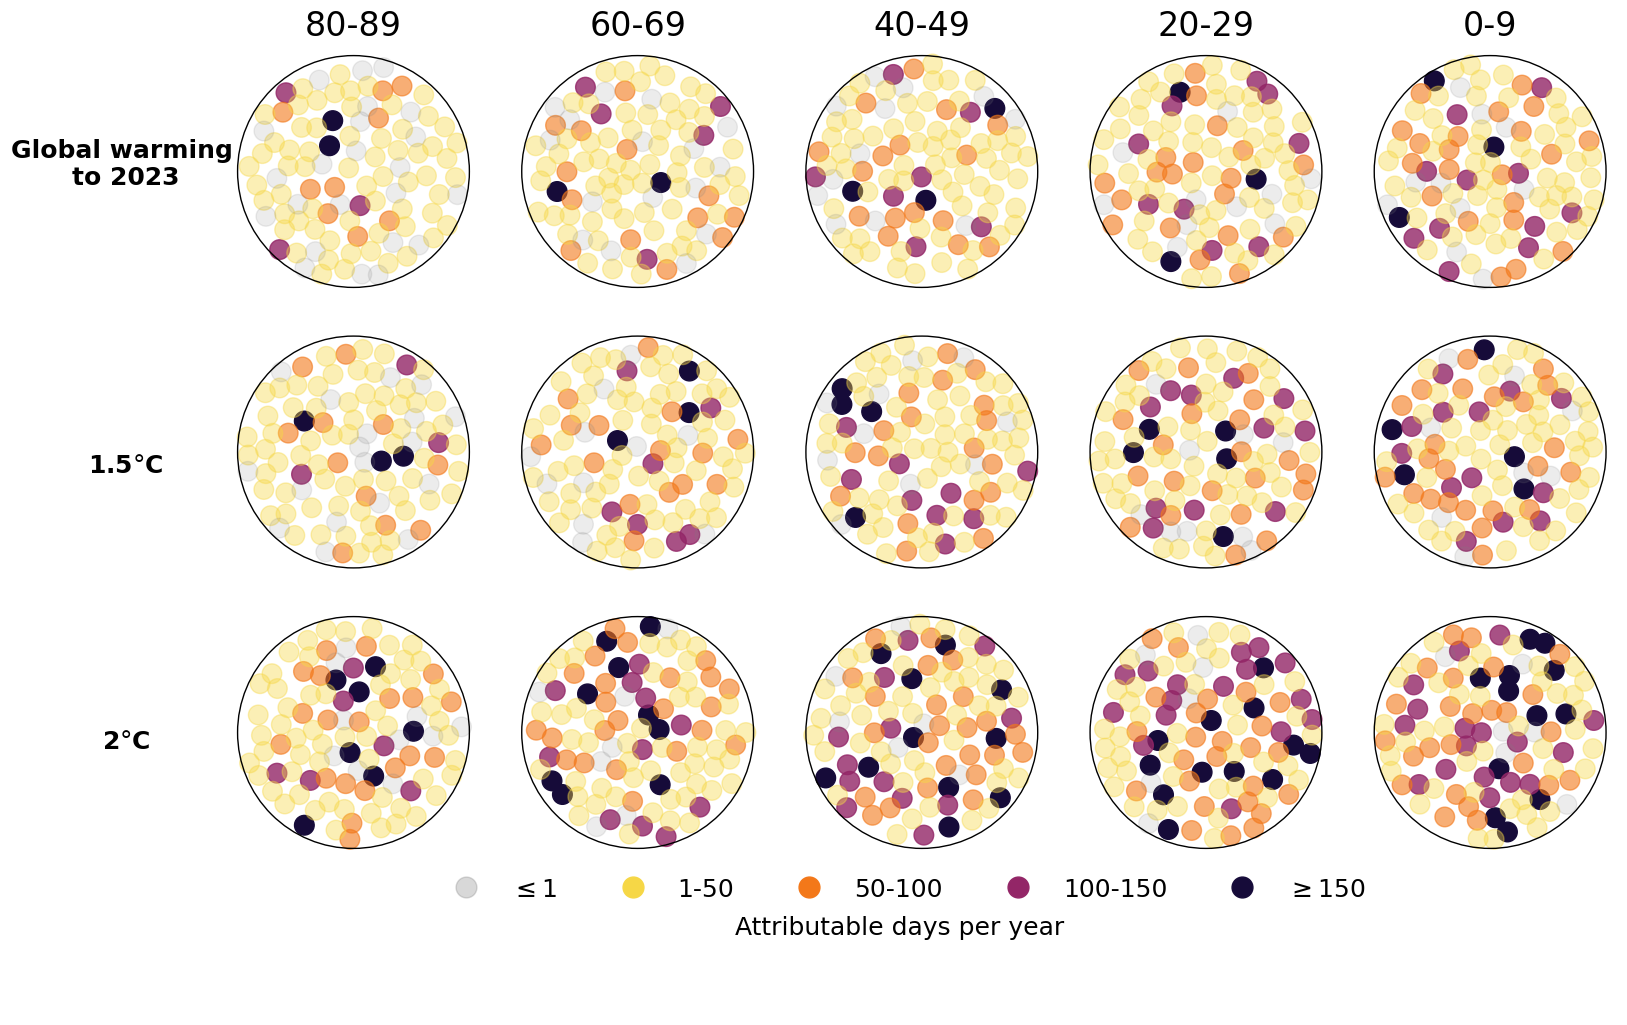

In [42]:
plot_petri_dish_2lvls(col_lvls,al_lvls, col_lvls_15,al_lvls_15, col_lvls_2,al_lvls_2,
                          nrows=3)

# Save the figure
# plt.savefig(os.path.join(figdir, 'fig3.png'), dpi=300, bbox_inches='tight', transparent=True)
# plt.savefig(os.path.join(figdir, 'fig3.pdf'), dpi=300, bbox_inches='tight', transparent=True)


# Corresponding number of people



In [52]:
pct = da_prop_people_ndays_models.sel(age_ranges=0).to_pandas().median(axis=0)['prop_atleast_150']
print(pct)

nyoung = gs_population_global_2023.sel(ages=0).sum().values * pct
nyoung


# 3% of 0-9 cohort at PD warming levels 

0.03283302507353085


4285270.55667048

In [54]:
pct = da_prop_people_ndays_models.sel(age_ranges=60).to_pandas().median(axis=0)['prop_atleast_150']
print(pct)

nold = gs_population_global_2023.sel(ages=60).sum().values * pct
nold


0.02445576623020739


1844558.1712654447

In [61]:
print(nyoung - nold)
nyoung/nold

2440712.3854050357


2.3231962122021903

In [63]:
pct = da_prop_people_ndays_models_15.sel(age_ranges=0).to_pandas().median(axis=0)['prop_atleast_150']
print(pct)

nyoung = gs_population_global_2034.sel(ages=0).sum().values * pct
nyoung

0.05307353775383036


6622176.492365322

In [64]:
pct = da_prop_people_ndays_models_15.sel(age_ranges=60).to_pandas().median(axis=0)['prop_atleast_150']
print(pct)

nold = gs_population_global_2034.sel(ages=60).sum().values * pct
nold

0.03492798044398167


3089096.20436788

In [65]:
nyoung-nold

3533080.2879974423

In [67]:
pct = da_prop_people_ndays_models_2.sel(age_ranges=0).to_pandas().median(axis=0)['prop_atleast_150']
print(pct)

nyoung = gs_population_global_2062.sel(ages=0).sum().values * pct
nyoung 

0.12385689756772489


13416231.430720493

In [68]:
pct = da_prop_people_ndays_models_2.sel(age_ranges=60).to_pandas().median(axis=0)['prop_atleast_150']
print(pct)

nold =gs_population_global_2062.sel(ages=60).sum().values * pct
nold

0.08952550208217011


9653315.320146091

In [69]:
nyoung-nold

3762916.110574402

In [70]:
gs_population_global_2062.sel(ages=0).sum().values

array(1.08320422e+08)

In [71]:
gs_population_global_2062.sel(ages=60).sum().values

array(1.07827547e+08)

In [72]:
# check sensitivity to year chosen : 
# al

gs_population_global_2050.sel(ages=60).sum().values * pct

9821800.728687616

# Extra

## Test: if demographics were constant at present-day levels + 1.5 climate

Not a huge difference

80 [1.0, 0.8, 0.17, 0.06, 0.02]
60 [1.0, 0.86, 0.24, 0.09, 0.03]
40 [1.0, 0.9, 0.29, 0.12, 0.04]
20 [1.0, 0.91, 0.35, 0.15, 0.05]
0 [1.0, 0.91, 0.39, 0.17, 0.05]
80 [1.0, 0.85, 0.24, 0.09, 0.04]
60 [1.0, 0.9, 0.32, 0.13, 0.06]
40 [1.0, 0.93, 0.39, 0.17, 0.08]
20 [1.0, 0.94, 0.46, 0.22, 0.1]
0 [1.0, 0.94, 0.5, 0.26, 0.11]


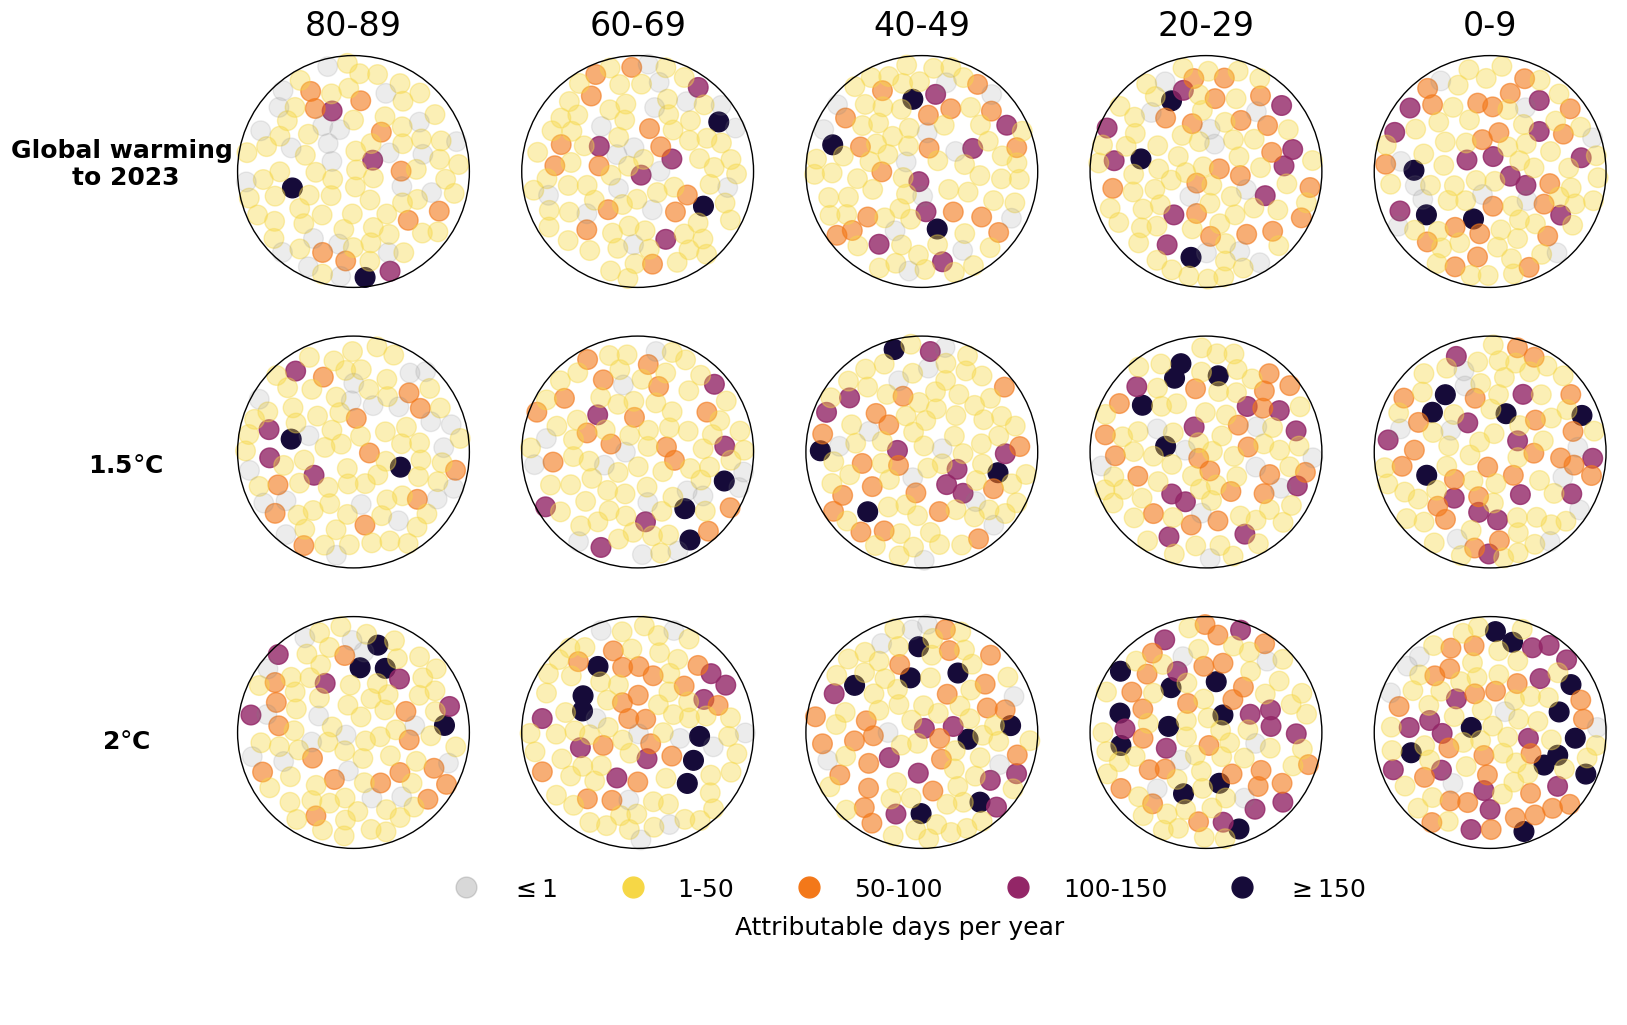

In [23]:
x_hot_days = [0, 1, 50, 100, 150]

year=2023

temp_target=1.5

da_nAHD = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, temp_target=temp_target) 

da_n_people_ndays_models_15_fd, da_prop_people_ndays_models_15_fd = calc_number_proportion_people_atleastxdays_10yr(gs_population_global_2023, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = x_hot_days)



col_lvls_15_fd, al_lvls_15_fd = prep_data_petri_dish(da_prop_people_ndays_models_15_fd)



da_nAHD = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, temp_target=2) 

da_n_people_ndays_models_2_fd, da_prop_people_ndays_models_2_fd = calc_number_proportion_people_atleastxdays_10yr(gs_population_global_2023, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = x_hot_days)



col_lvls_2_fd, al_lvls_2_fd = prep_data_petri_dish(da_prop_people_ndays_models_2_fd)

plot_petri_dish_2lvls(col_lvls,al_lvls,col_lvls_15_fd,al_lvls_15_fd,col_lvls_2_fd, al_lvls_2_fd, nrows=3)


80 [1.0, 0.82, 0.17, 0.06, 0.03]
60 [1.0, 0.89, 0.25, 0.1, 0.03]
40 [1.0, 0.9, 0.31, 0.13, 0.04]
20 [1.0, 0.91, 0.37, 0.16, 0.05]
0 [1.0, 0.92, 0.41, 0.18, 0.05]
80 [1.0, 0.9, 0.33, 0.13, 0.07]
60 [1.0, 0.93, 0.43, 0.2, 0.09]
40 [1.0, 0.94, 0.48, 0.24, 0.11]
20 [1.0, 0.94, 0.53, 0.28, 0.12]
0 [1.0, 0.94, 0.54, 0.29, 0.12]
guard reached.


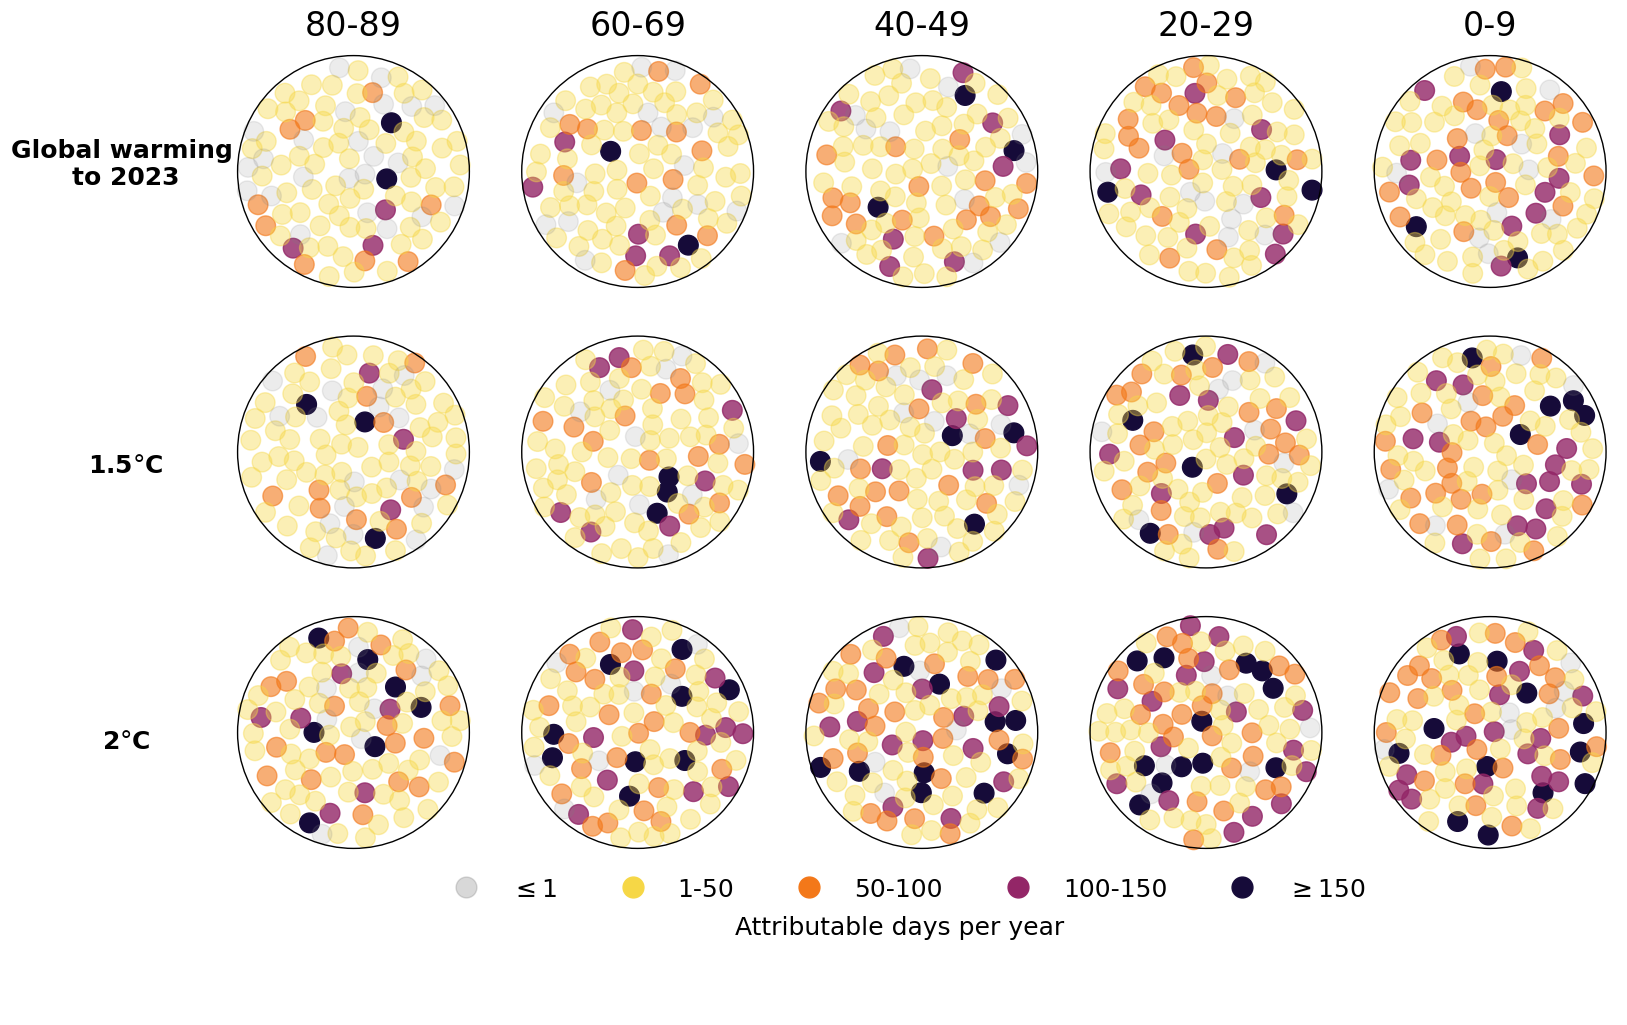

In [24]:
x_hot_days = [0, 1, 50, 100, 150]

# TEST TO CHECK ABOVE OK 


year=2023

temp_target=1.5

da_nAHD = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, temp_target=temp_target) 

da_n_people_ndays_models_15_fd, da_prop_people_ndays_models_15_fd = calc_number_proportion_people_atleastxdays_10yr(gs_population_global_2034, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = x_hot_days)



col_lvls_15_fd, al_lvls_15_fd = prep_data_petri_dish(da_prop_people_ndays_models_15_fd)



da_nAHD = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, temp_target=2) 

da_n_people_ndays_models_2_fd, da_prop_people_ndays_models_2_fd = calc_number_proportion_people_atleastxdays_10yr(gs_population_global_2062, 
                                                                                          GCMs, 
                                                                                          da_nAHD,  
                                                                                          x_hot_days = x_hot_days)



col_lvls_2_fd, al_lvls_2_fd = prep_data_petri_dish(da_prop_people_ndays_models_2_fd)

plot_petri_dish_2lvls(col_lvls,al_lvls,col_lvls_15_fd,al_lvls_15_fd,col_lvls_2_fd, al_lvls_2_fd, nrows=3)

## Try absolute n of days, not attributable 

With demographics fixed at present-day?? Or correct in their year?? I think better correct in their year

In [25]:
x_hot_days = [0, 1, 50, 150, 250]


In [26]:
da_p0, da_p1 = open_all_p0_p1(GCMs, metric='WBGT28', outdirname=dirname, year_pres=2023)

da_totdays_pi = da_p0 * 365

da_n_people_ndays_models_pi, da_prop_people_ndays_models_pi = calc_number_proportion_people_atleastxdays_10yr(gs_population_global_2023, # dont have demographics until 1950
                                                                                          GCMs, 
                                                                                          da_totdays_pi,  
                                                                                          x_hot_days = x_hot_days)

da_totdays_pres = da_p1 * 365

da_n_people_ndays_models_pres, da_prop_people_ndays_models_pres = calc_number_proportion_people_atleastxdays_10yr(gs_population_global_2023, 
                                                                                          GCMs, 
                                                                                          da_totdays_pres,  
                                                                                          x_hot_days = x_hot_days)



In [27]:
da_p0, da_p1 = open_all_p0_p1(GCMs, metric='WBGT28', outdirname=dirname, temp_target = 1.5)

da_n_people_ndays_models_15, da_prop_people_ndays_models_15 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global_2034, 
                                                                                          GCMs, 
                                                                                          da_p1 * 365,  
                                                                                          x_hot_days = x_hot_days)

In [28]:
da_p0, da_p1 = open_all_p0_p1(GCMs, metric='WBGT28', outdirname=dirname, temp_target = 2)

da_n_people_ndays_models_2, da_prop_people_ndays_models_2 = calc_number_proportion_people_atleastxdays_10yr(gs_population_global_2062, 
                                                                                          GCMs, 
                                                                                          da_p1 * 365,  
                                                                                          x_hot_days = x_hot_days)

In [29]:
col_lvls_pi, al_lvls_pi = prep_data_petri_dish(da_prop_people_ndays_models_pi)
col_lvls_pres, al_lvls_pres = prep_data_petri_dish(da_prop_people_ndays_models_pres)
col_lvls_15, al_lvls_15 = prep_data_petri_dish(da_prop_people_ndays_models_15)
col_lvls_2, al_lvls_2 = prep_data_petri_dish(da_prop_people_ndays_models_2)


80 [1.0, 0.64, 0.26, 0.09, 0.0]
60 [1.0, 0.74, 0.37, 0.14, 0.01]
40 [1.0, 0.78, 0.44, 0.17, 0.01]
20 [1.0, 0.81, 0.5, 0.2, 0.01]
0 [1.0, 0.81, 0.51, 0.2, 0.01]
80 [1.0, 0.78, 0.36, 0.19, 0.04]
60 [1.0, 0.85, 0.48, 0.28, 0.06]
40 [1.0, 0.89, 0.56, 0.35, 0.07]
20 [1.0, 0.91, 0.62, 0.43, 0.08]
0 [1.0, 0.91, 0.65, 0.44, 0.09]
80 [1.0, 0.83, 0.4, 0.2, 0.05]
60 [1.0, 0.89, 0.54, 0.31, 0.08]
40 [1.0, 0.91, 0.61, 0.39, 0.09]
20 [1.0, 0.92, 0.66, 0.46, 0.1]
0 [1.0, 0.92, 0.69, 0.49, 0.11]
80 [1.0, 0.93, 0.63, 0.32, 0.12]
60 [1.0, 0.95, 0.75, 0.48, 0.17]
40 [1.0, 0.96, 0.77, 0.52, 0.19]
20 [1.0, 0.96, 0.79, 0.56, 0.21]
0 [1.0, 0.96, 0.79, 0.57, 0.22]


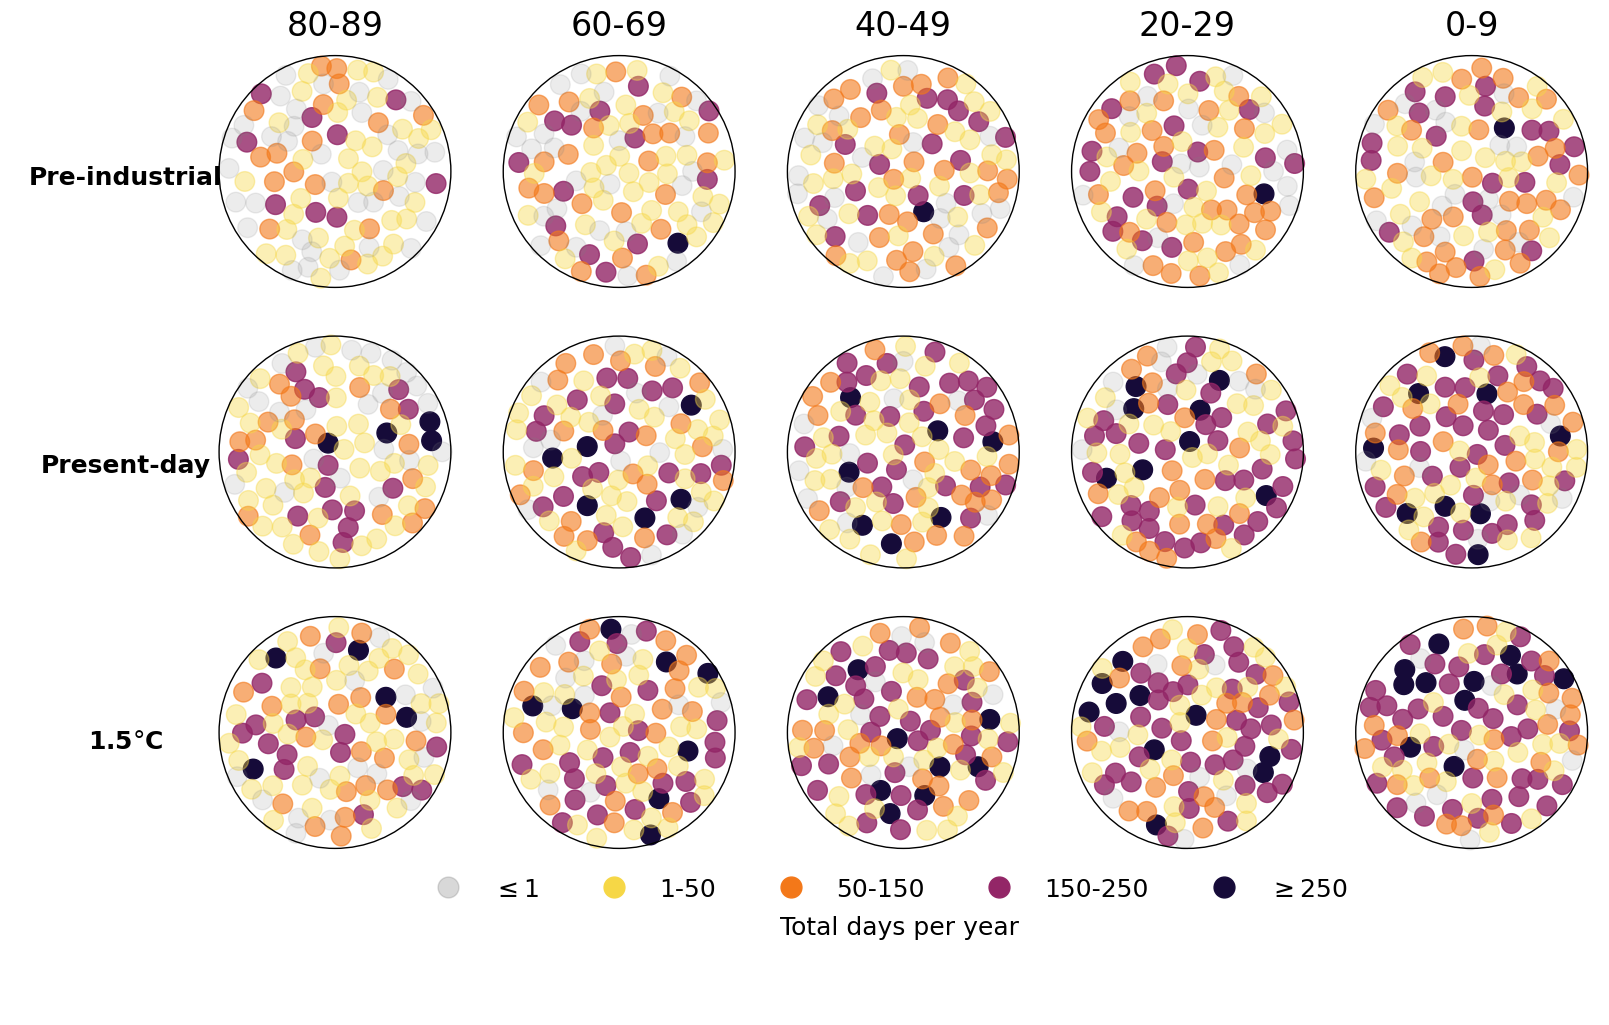

In [30]:
plot_petri_dish_2lvls(col_lvls_pi,al_lvls_pi, col_lvls_pres,al_lvls_pres, col_lvls_15,al_lvls_15,
                          nrows=3, 
                     labels = ['Pre-industrial','Present-day', '1.5$\degree$C' ],
                     legtitle='Total days per year')